# **CS 5393-006 Final Project: Chess ID**
**Matias Barcelo Treiyer**  
**December 2, 2024**

Github Repo: https://github.com/matiasbarcelo/chess-id


# Converting the Dataset to Numpy Arrays

In [1]:
import os
import cv2
import numpy as np

## Load Image Function

For each dir in the train dir  
For each file in the dir  
Grayscale the image, flatten the image into a 1D array, and make the name of the dir the label

In [2]:
def load_images_from_folder(folder):
    names_of_file = []
    images = []
    labels = []
    for dir_name in os.listdir(folder):
        dir_path = os.path.join(folder, dir_name)
        if os.path.isdir(dir_path):
            for filename in os.listdir(dir_path):
                img_path = os.path.join(dir_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_flattened = img.flatten()
                    images.append(img_flattened)
                    labels.append(dir_name)
                    names_of_file.append(filename)
    return np.array(names_of_file), np.array(images), np.array(labels)

## Testing out visualization logic on a test image

In [3]:
# Define test_imag function to test on "test_black_bishop.jpg"
def test_img(img_path, label):
    images = []
    labels = []
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape[:2]
    if img is not None:
        img_flattened = img.flatten()
        images.append(img_flattened)
        labels.append(label)
    return np.array(images), np.array(labels), height, width

In [4]:
# use function and explore a bit
test_image_np_array, test_label, h, w = test_img("test_black_bishop.jpg", "bb")

print(test_image_np_array.shape)
print(test_image_np_array.dtype)
print(h, w)

(1, 51529)
uint8
227 227


In [5]:
from matplotlib import pyplot as plt

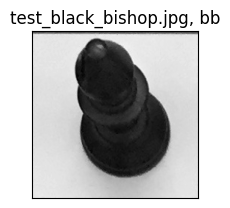

In [6]:
# testing on the test image

def plot_bishop(images, filename, label, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(filename + ", " + label[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_bishop(test_image_np_array, "test_black_bishop.jpg", test_label, h, w, 1, 1) # defaults to showing a 3 by 6 subset of the faces

## Loading up data

In [7]:
train_folder = "Chess ID Public Data\output_train"
test_folder = "Chess ID Public Data\output_test"

np_name_train, np_uint8_image_train, np_label_train = load_images_from_folder(train_folder)
np_name_test, np_uint8_image_test, np_label_test = load_images_from_folder(test_folder)

In [8]:
print(np_uint8_image_train.shape)
print(np_label_train)

(10360, 51529)
['bb' 'bb' 'bb' ... 'wr' 'wr' 'wr']


# Finding principle components/eigenvalues

In [9]:
from sklearn.decomposition import PCA

In [10]:
# 185 because there are only 185 test images
n_components = 185

pca = PCA(n_components=n_components)
pca.fit(np_uint8_image_train)
eigenpieces = pca.components_.reshape((n_components, h, w)) # These are the 300 principle components

In [11]:
np_uint8_image_train_pca_transform = pca.transform(np_uint8_image_train)

In [12]:
pca.components_.shape

(185, 51529)

In [13]:
eigenpieces.shape

(185, 227, 227)

In [14]:
np_uint8_image_train_pca_transform.shape

(10360, 185)

## Visualizing Result

In [15]:
def plot_eigenpieces(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("Eigenpiece " + str(i + 1), size=12)
        plt.xticks(())
        plt.yticks(())

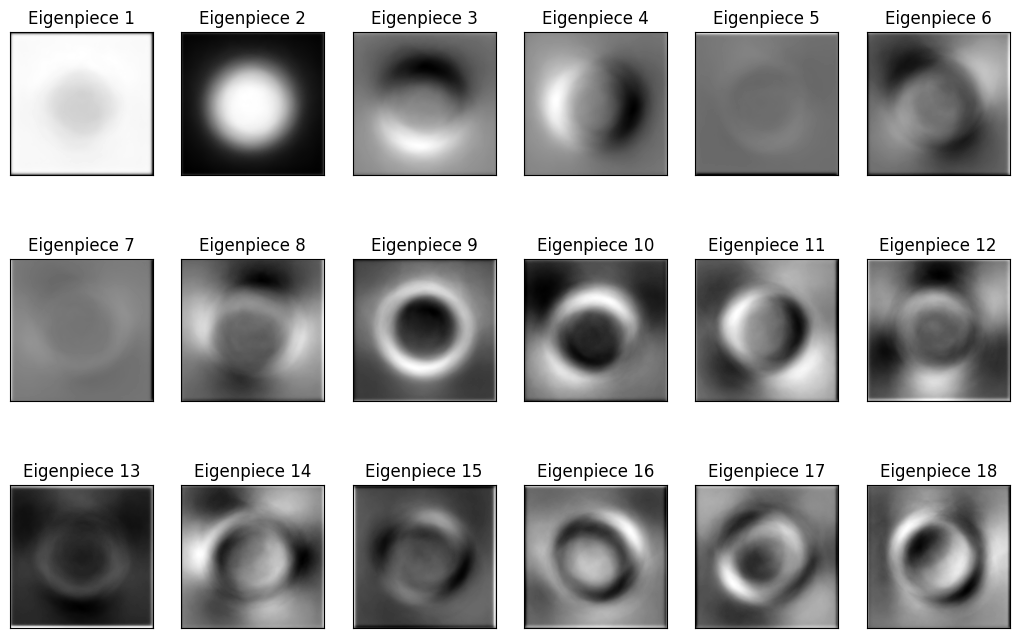

In [16]:
# I assumed that these were coorilated with file name and label because of how it was presented in the PCA example in class, but I rationaled that it didn't make much sense

plot_eigenpieces(eigenpieces, h, w)

# Running MLP Nueral Nets

## Nueral Net with Principal Components, both normalized and not normalized

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

In [30]:
# need to transform test as well
pca = PCA(n_components=185)
np_uint8_image_test_pca_transform = pca.fit_transform(np_uint8_image_test)

In [31]:
# normalize everything
scaler = StandardScaler()

np_uint8_image_train_pca_transform_scaled = scaler.fit_transform(np_uint8_image_train_pca_transform)
np_uint8_image_test_pca_transform_scaled = scaler.fit_transform(np_uint8_image_test_pca_transform)

In [32]:
# Make a neural net object
mlp_nn = MLPClassifier()

# PCA nueral net for not scaled
mlp_pca = mlp_nn.fit(np_uint8_image_train_pca_transform, np_label_train)

In [33]:
# PCA Nueral net scaled
mlp_scaled_pca = mlp_nn.fit(np_uint8_image_train_pca_transform_scaled, np_label_train)

In [34]:
# Predict Classification with PCA NN
label_predict_mlp_pca = mlp_pca.predict(np_uint8_image_test_pca_transform)

# Predict Classification with PCA Scaled
label_predict_mlp_scaled_pca = mlp_scaled_pca.predict(np_uint8_image_test_pca_transform_scaled)

### Nueral Net with PCA not scaled results

In [43]:
# results not scaled
unique_labels = np.unique(np.concatenate((np_label_test, label_predict_mlp_pca)))
accuracy_pca = accuracy_score(np_label_test, label_predict_mlp_pca)

print("Nueral Network with PCA Unscaled Data")

# Use unique labels in classification_report
print(classification_report(np_label_test, label_predict_mlp_pca, labels=unique_labels))
print(f"Accuracy: {accuracy_pca:.2f}")

# See that the model tried to predict at least
print(np.unique(label_predict_mlp_pca))

Nueral Network with PCA Unscaled Data
              precision    recall  f1-score   support

          bb       0.17      0.12      0.14         8
          bk       0.00      0.00      0.00        10
          bn       0.09      0.86      0.17         7
          bp       0.87      0.26      0.40        50
          bq       0.00      0.00      0.00         6
          br       0.00      0.00      0.00         9
       empty       0.00      0.00      0.00         0
          wb       0.00      0.00      0.00         7
          wk       0.00      0.00      0.00        10
          wn       0.00      0.00      0.00        11
          wp       0.33      0.10      0.15        52
          wq       0.05      0.33      0.09         6
          wr       0.33      0.11      0.17         9

    accuracy                           0.15       185
   macro avg       0.14      0.14      0.09       185
weighted avg       0.36      0.15      0.17       185

Accuracy: 0.15
['bb' 'bk' 'bn' 'bp' 'bq' 

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMet

### Nueral Net with PCA Scaled Results

In [42]:
# results scaled
unique_labels = np.unique(np.concatenate((np_label_test, label_predict_mlp_scaled_pca)))
accuracy_pca = accuracy_score(np_label_test, label_predict_mlp_scaled_pca)

print("Nueral Network with PCA Scaled Data")

# Use unique labels in classification_report
print(classification_report(np_label_test, label_predict_mlp_scaled_pca, labels=unique_labels))
print(f"Accuracy: {accuracy_pca:.2f}")

# See that the model tried to predict at least
print(np.unique(label_predict_mlp_scaled_pca))

Nueral Network with PCA Scaled Data
              precision    recall  f1-score   support

          bb       0.17      0.25      0.20         8
          bk       0.25      0.20      0.22        10
          bn       0.08      0.14      0.11         7
          bp       0.62      0.40      0.49        50
          bq       0.11      0.17      0.13         6
          br       0.00      0.00      0.00         9
       empty       0.00      0.00      0.00         0
          wb       0.10      0.14      0.12         7
          wk       0.20      0.20      0.20        10
          wn       0.23      0.27      0.25        11
          wp       0.45      0.33      0.38        52
          wq       0.00      0.00      0.00         6
          wr       0.00      0.00      0.00         9

    accuracy                           0.26       185
   macro avg       0.17      0.16      0.16       185
weighted avg       0.35      0.26      0.30       185

Accuracy: 0.26
['bb' 'bk' 'bn' 'bp' 'bq' 'b

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Nueral Net Normalized without Principle Components as is (Takes a long time to load)

In [37]:
np_uint8_image_train_scaled = scaler.fit_transform(np_uint8_image_train)
np_uint8_image_test_scaled = scaler.fit_transform(np_uint8_image_test)

In [38]:
# No PCA nueral net
mlp_no_pca = mlp_nn.fit(np_uint8_image_train_scaled, np_label_train)

In [39]:
# Predict Classification with normal NN
label_predict_mlp_no_pca = mlp_no_pca.predict(np_uint8_image_test_scaled)

In [41]:
unique_labels = np.unique(label_predict_mlp_no_pca)
accuracy_no_pca = accuracy_score(np_label_test, label_predict_mlp_no_pca)
 
print("Neural Network No PCA with Normalized Data")

# Use unique labels in classification_report
print(classification_report(np_label_test, label_predict_mlp_no_pca, labels=unique_labels))
print(f"Accuracy: {accuracy_no_pca:.2f}")

print(unique_labels)

Neural Network No PCA with Normalized Data
              precision    recall  f1-score   support

          bb       0.00      0.00      0.00         8
          bk       0.67      0.60      0.63        10
          bn       0.20      0.29      0.24         7
          bp       0.91      0.80      0.85        50
          bq       0.20      0.17      0.18         6
          br       0.10      0.11      0.11         9
       empty       0.00      0.00      0.00         0
          wb       0.10      0.14      0.12         7
          wk       0.56      0.50      0.53        10
          wn       0.18      0.18      0.18        11
          wp       0.96      0.48      0.64        52
          wq       0.00      0.00      0.00         6
          wr       0.18      0.33      0.23         9

    accuracy                           0.46       185
   macro avg       0.31      0.28      0.28       185
weighted avg       0.62      0.46      0.52       185

Accuracy: 0.46
['bb' 'bk' 'bn' 'bp' 

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
